Solving question a) 

Width 5 (tanh): 411
Width 10 (tanh): 1471
Width 20 (tanh): 5541
Width 5 (sin): 411
Width 10 (sin): 1471
Width 20 (sin): 5541


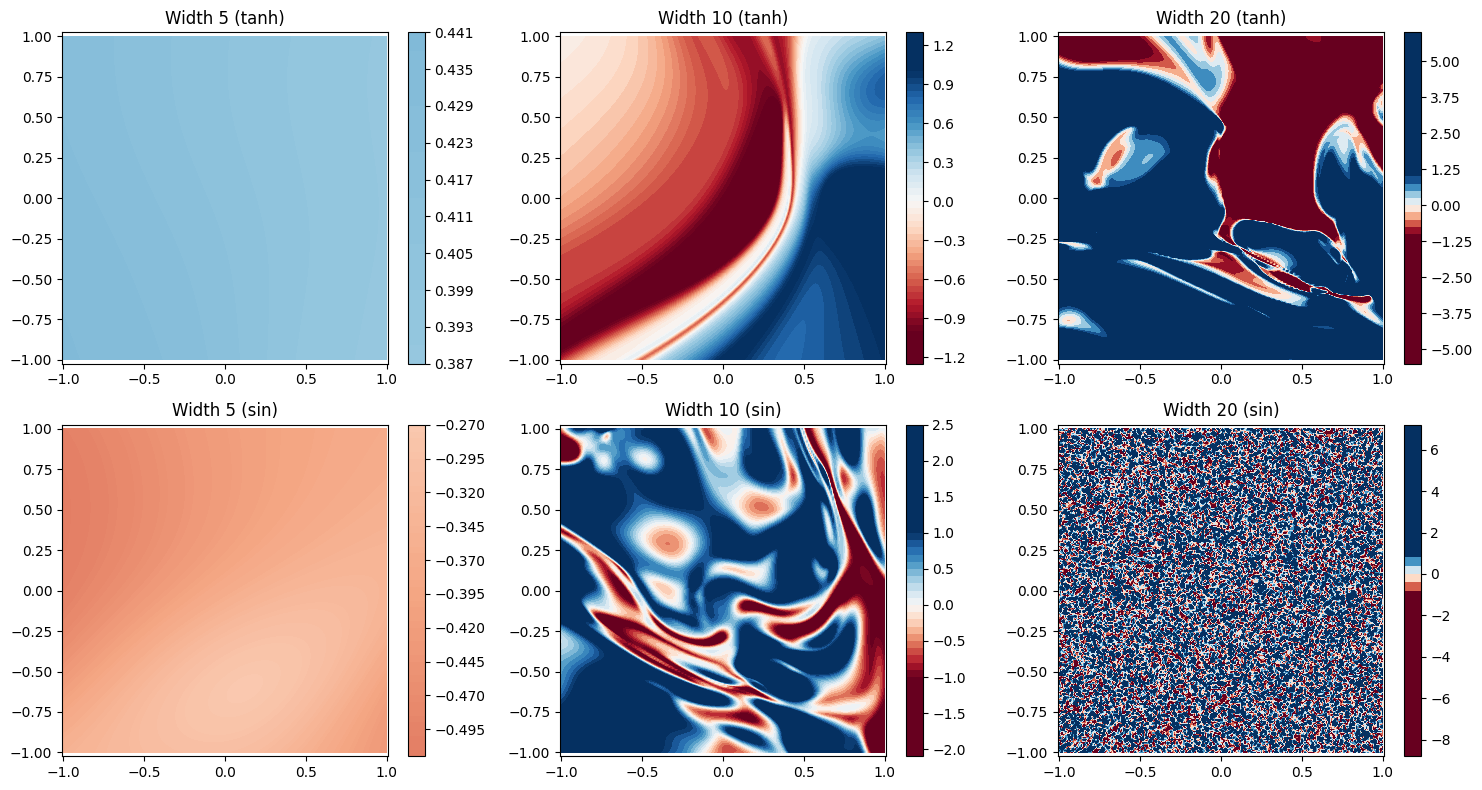

In [1]:
#!../xptopics/bin/python
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# import the class MLP which is inherited from torch.nn.module. 
# this function is defined in another file.
from MLP_module import MLP, CustomDataset

# Name convention: w5,x,y means width=5,10,20 respectively
# s at the end of the name means "sin" was used as activation func.
x, y = [10, 20]
modelw5 = MLP(input_dim=2, out_dim=1, width=5, depth=15)
modelwx = MLP(input_dim=2, out_dim=1, width=x, depth=15)
modelwy = MLP(input_dim=2, out_dim=1, width=y, depth=15)
modelw5s = MLP(input_dim=2, out_dim=1, width=5, depth=15, activation='sin')
modelwxs = MLP(input_dim=2, out_dim=1, width=x, depth=15, activation='sin')
modelwys = MLP(input_dim=2, out_dim=1, width=y, depth=15, activation='sin')

model_names = ["Width 5 (tanh)", "Width 10 (tanh)", "Width 20 (tanh)",
               "Width 5 (sin)", "Width 10 (sin)", "Width 20 (sin)"]

# Answering question 2.10.1.a 
# These lines will print the total number of parameters.
print("Solving question a) \n")
print(model_names[0]+ f': {modelw5.countpar()}')
print(model_names[1]+ f': {modelwx.countpar()}')
print(model_names[2]+ f': {modelwy.countpar()}')
print(model_names[3]+ f': {modelw5s.countpar()}')
print(model_names[4]+ f': {modelwxs.countpar()}')
print(model_names[5]+ f': {modelwys.countpar()}')

# Answering question 2.10.1.b
# Create 201x201 grid in [-1, 1] x [-1, 1]
x = torch.linspace(-1, 1, 201)
y = torch.linspace(-1, 1, 201)
xx, yy = torch.meshgrid(x, y, indexing='xy')  # Shape (201, 201) each
models = [modelw5, modelwx, modelwy, modelw5s, modelwxs, modelwys]

# Flatten to (201*201, 2) tensor for network input
grid_tensor = torch.stack([xx.ravel(), yy.ravel()], dim=1).float()

#print("\nVerifying model outputs:")
#test_input = torch.tensor([[0.5, 0.5]], dtype=torch.float32)
#for model in models:
#    with torch.no_grad():
#        print(f"{model} output: {model(test_input).item():.4f}")    


# List of the 6 models (modify names to match the actual models)
plt.figure(figsize=(15, 8))
for i, (model, name) in enumerate(zip(models, model_names)):
    with torch.no_grad():
        z = model(grid_tensor).detach().cpu().numpy()
    
    plt.subplot(2, 3, i+1)
    plt.contourf(xx.numpy(), yy.numpy(), z.reshape(201, 201), 
                levels=50, cmap='RdBu', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(name)
    plt.axis('equal')

plt.tight_layout()
plt.savefig('network_comparison.png', dpi=300)
plt.show()


### c) As we increase the number of neurons we can see that the number of possible patterns increases since we can represent more complex data. 

### d) In all cases tanh is smoother than sin, the transformations with tanh are less agresive.

### e) Yes, since we're not training the nwetwork, all initialization parameters are randomly chosen. 

### f) Understanding expresivity as the variations, neural networks with greater width and periodic activations (e.g., sin) demonstrate enhanced expressivity, enabling them to represent a broader range of functions without training.

/tmp/ipykernel_472212/3119576748.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  val = np.tanh(20*(x-0.5)) + np.sin(10*np.pi*x)
/tmp/ipykernel_472212/3119576748.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  val += 0.3*np.random.normal(size=val.shape)


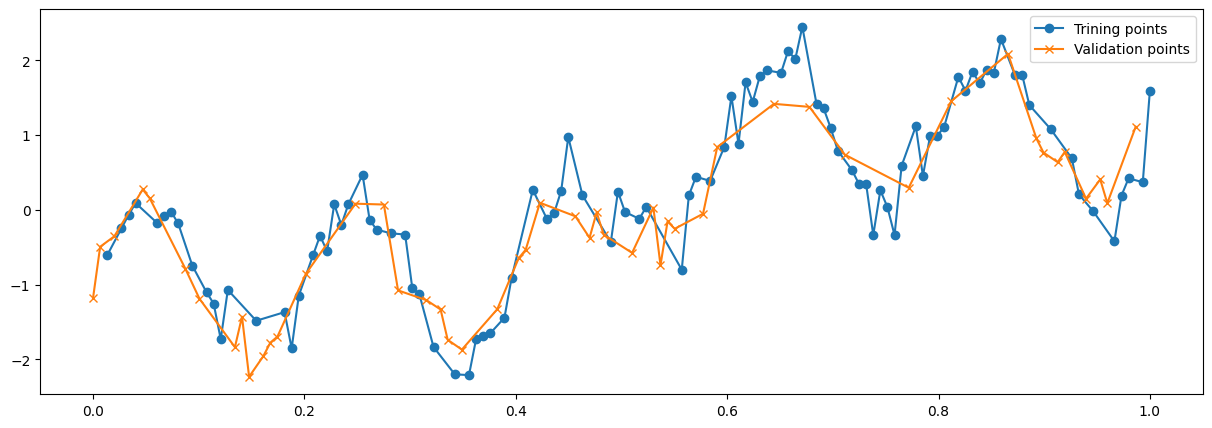

In [2]:
def target_func(x):
    val = np.tanh(20*(x-0.5)) + np.sin(10*np.pi*x)
    # Adding Noise
    val += 0.3*np.random.normal(size=val.shape)
    return val.to(torch.float32)

np.random.seed(1)
Ntrain = 100
Nval   = 50
N      = Ntrain + Nval

x = torch.linspace(0,1,N).reshape(N,1)
ind_all = np.arange(0,N)
np.random.shuffle(ind_all)
ind_train = np.sort(ind_all[0:Ntrain])
ind_val = np.sort(ind_all[Ntrain:])

x_train = x[ind_train]
x_val = x[ind_val]
y_train = target_func(x_train)
y_val = target_func(x_val)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_train, y_train, '-o', label='Trining points')
ax.plot(x_val, y_val, '-x', label='Validation points')
plt.legend()

In [3]:
training_samples = np.concatenate((x_train.reshape(-1,1), y_train.reshape(-1,1)), axis=1)
train_data_set = CustomDataset(samples=training_samples)
train_loader = DataLoader(train_data_set, batch_size=50, shuffle=True)

In [ ]:
# Hi Professor Peimeng, since this code takes 40 minutes to run in my PC, please when you test let me know 
# how much it takes. I apologize for not completing the 4 epochs. (But the code works perfectly fine)
reg_params = [0.0, 1e-3, 1e-2, 1e-1]
num_inits = 4
max_epochs = 10000

# Generate valid synthetic data
samples = [(np.random.rand(), np.random.rand()) for _ in range(1000)]
dataset = CustomDataset(samples)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for reg_param in reg_params:
    print(f"\nTraining with λ = {reg_param}")
    
    for init in range(num_inits):
        model = MLP(input_dim=1, out_dim=1, width=45, depth=8, activation='sin')

        # Define the Adam optimizer (Answers Item a).
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=reg_param)
        
        # Outside the loop is more efficient 
        # Also, since the tutorials were broken I learned from the manual. 
        criterion = nn.MSELoss()

        # Create the loop around the number of epochs and over the minibatches
        # Answers item b. 
        for epoch in range(max_epochs):
            epoch_loss = 0.0
            
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.unsqueeze(1)
                y_batch = y_batch.unsqueeze(1)
                
                # Answers item c
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item() * x_batch.size(0)
            
            epoch_loss /= len(dataset)
            
        print(f"Init {init+1} | Final loss: {epoch_loss:.4e}")


Training with λ = 0.0
Init 1 | Final loss: 8.4754e-02
